In [1]:
from keras.datasets import fashion_mnist, mnist
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd# Any results you write to the current directory are saved as output.
from IPython.display import display, Image

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

# Any results you write to the current directory are saved as output.
from IPython.display import display, Image

In [2]:
# get the data
filname = '/content/drive/MyDrive/machine learning projects/training set/Facial Expression/fer2013/fer2013.csv'

#different labels of images(not useful known about for current problem)
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#different features names
names=['emotion','pixels','usage']

#Reading data in dataframe
df=pd.read_csv(filname,names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [3]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [4]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [5]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [6]:
#splitting data in train, test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [7]:
#Taking 5000 images 

x_train = x_train[:5000]
x_test = x_test[:5000]

In [8]:
x_train.shape

(5000, 48, 48, 1)

In [9]:
#NOrmalizing the images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#reshaping the images
x_train = np.reshape(x_train, (len(x_train), 48, 48, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 48, 48, 1))  # adapt this if using `channels_first` image data format


#adding noise in data
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

#clipping put data near to 0--->0 aand data near to 1-->1(eg=0.3-->0 or 0.7-->1)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [10]:
n = 10

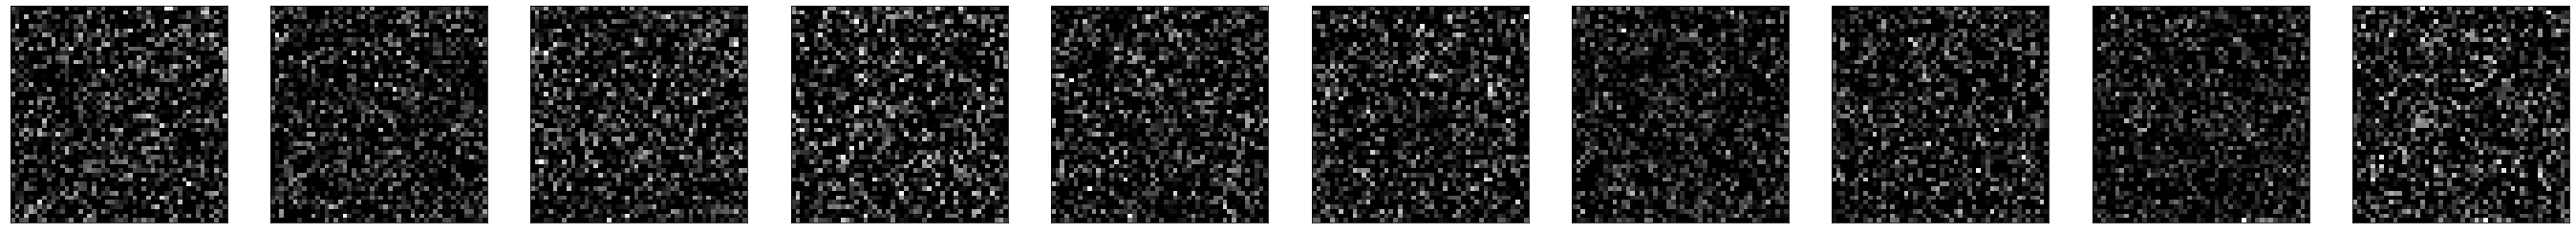

In [11]:
plt.figure(figsize=(48, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
input_img = Input(shape=(48, 48, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='MSE')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                         

In [13]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=35,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/35
79/79 [==============================] - 12s 19ms/step - loss: 0.0237 - val_loss: 6.2289e-06
Epoch 2/35
79/79 [==============================] - 1s 15ms/step - loss: 6.0227e-06 - val_loss: 6.0605e-06
Epoch 3/35
79/79 [==============================] - 1s 18ms/step - loss: 5.8881e-06 - val_loss: 5.8968e-06
Epoch 4/35
79/79 [==============================] - 1s 14ms/step - loss: 5.7346e-06 - val_loss: 5.7277e-06
Epoch 5/35
79/79 [==============================] - 1s 15ms/step - loss: 5.5765e-06 - val_loss: 5.5714e-06
Epoch 6/35
79/79 [==============================] - 1s 15ms/step - loss: 5.4432e-06 - val_loss: 5.4357e-06
Epoch 7/35
79/79 [==============================] - 1s 18ms/step - loss: 5.3276e-06 - val_loss: 5.3216e-06
Epoch 8/35
79/79 [==============================] - 1s 15ms/step - loss: 5.2358e-06 - val_loss: 5.2377e-06
Epoch 9/35
79/79 [==============================] - 1s 18ms/step - loss: 5.1709e-06 - val_loss: 5.1775e-06
Epoch 10/35
79/79 [=====================

<Figure size 432x288 with 0 Axes>

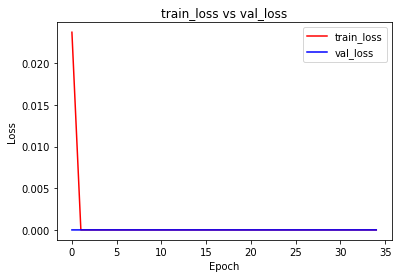

<Figure size 432x288 with 0 Axes>

In [14]:
epochs = range(len(autoencoder.history.history['loss']))

plt.plot(epochs,autoencoder.history.history['loss'],'r', label='train_loss')
plt.plot(epochs,autoencoder.history.history['val_loss'],'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

In [15]:
predict = autoencoder.predict(x_test_noisy)

In [16]:
n=10

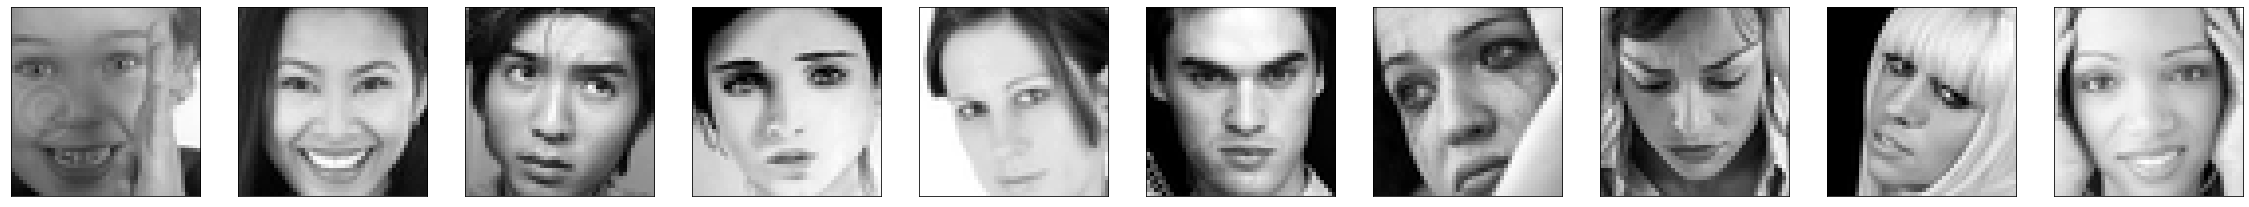

In [17]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

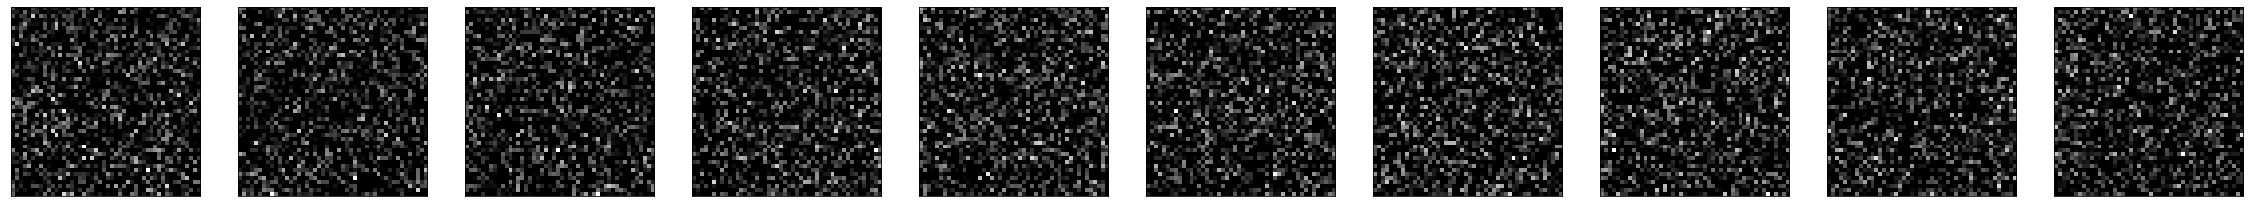

In [18]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

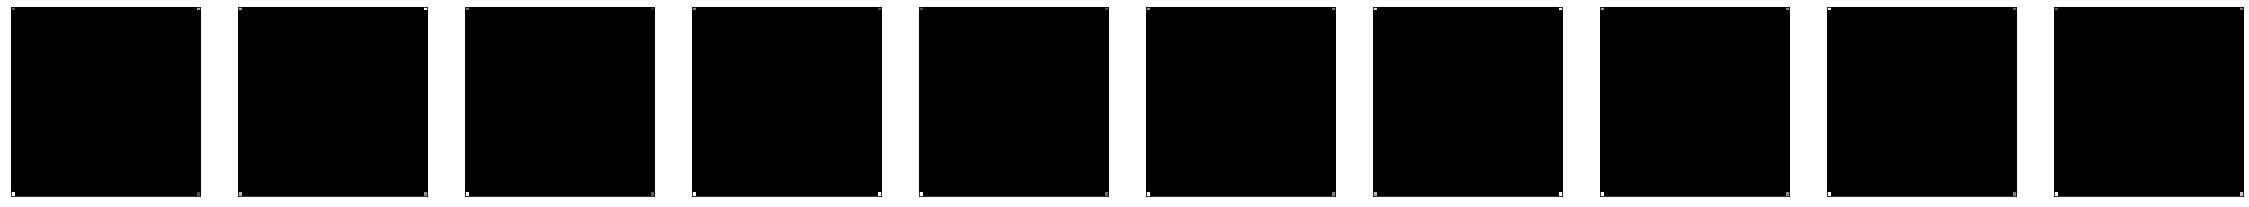

In [19]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
from skimage.metrics import structural_similarity as ssim
from skimage import data, img_as_float

In [22]:
ssim(x_test, predict, multichannel=True)

0.9890538670423291

In [23]:
input_img = Input(shape=(48,48,1))

x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x1 = MaxPooling2D((2, 2), padding='same')(x1)
x_drop = Dropout(0.2)(x1)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x_drop)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = concatenate([x,x1])
x = Dropout(0.2)(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_unet = Model(input_img, decoded)
autoencoder_unet.compile(optimizer='adam', loss='MSE')
autoencoder_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 48, 48, 32)   320         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 24, 24, 32)  0           ['conv2d_5[0][0]']               
                                                                                                  
 dropout_2 (Dropout)            (None, 24, 24, 32)   0           ['max_pooling2d_2[0][0]']        
                                                                                            

In [24]:
autoencoder_unet.fit(x_train_noisy, x_train,
                epochs=35,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/35
79/79 [==============================] - 4s 30ms/step - loss: 0.0203 - val_loss: 6.6271e-06
Epoch 2/35
79/79 [==============================] - 1s 16ms/step - loss: 6.1334e-06 - val_loss: 5.7351e-06
Epoch 3/35
79/79 [==============================] - 1s 19ms/step - loss: 5.4396e-06 - val_loss: 5.2830e-06
Epoch 4/35
79/79 [==============================] - 2s 22ms/step - loss: 5.1889e-06 - val_loss: 5.1310e-06
Epoch 5/35
79/79 [==============================] - 2s 22ms/step - loss: 5.0896e-06 - val_loss: 5.0641e-06
Epoch 6/35
79/79 [==============================] - 2s 22ms/step - loss: 5.0432e-06 - val_loss: 5.0330e-06
Epoch 7/35
79/79 [==============================] - 2s 24ms/step - loss: 5.0225e-06 - val_loss: 5.0172e-06
Epoch 8/35
79/79 [==============================] - 2s 23ms/step - loss: 5.0084e-06 - val_loss: 5.0088e-06
Epoch 9/35
79/79 [==============================] - 2s 24ms/step - loss: 5.0001e-06 - val_loss: 5.0037e-06
Epoch 10/35
79/79 [======================

In [25]:
predict = autoencoder_unet.predict(x_test_noisy)

In [26]:
n=10

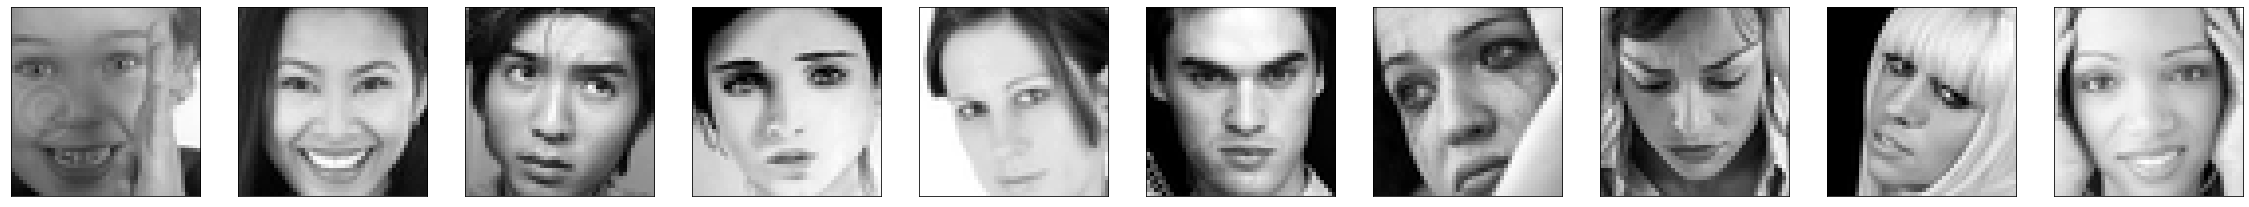

In [27]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

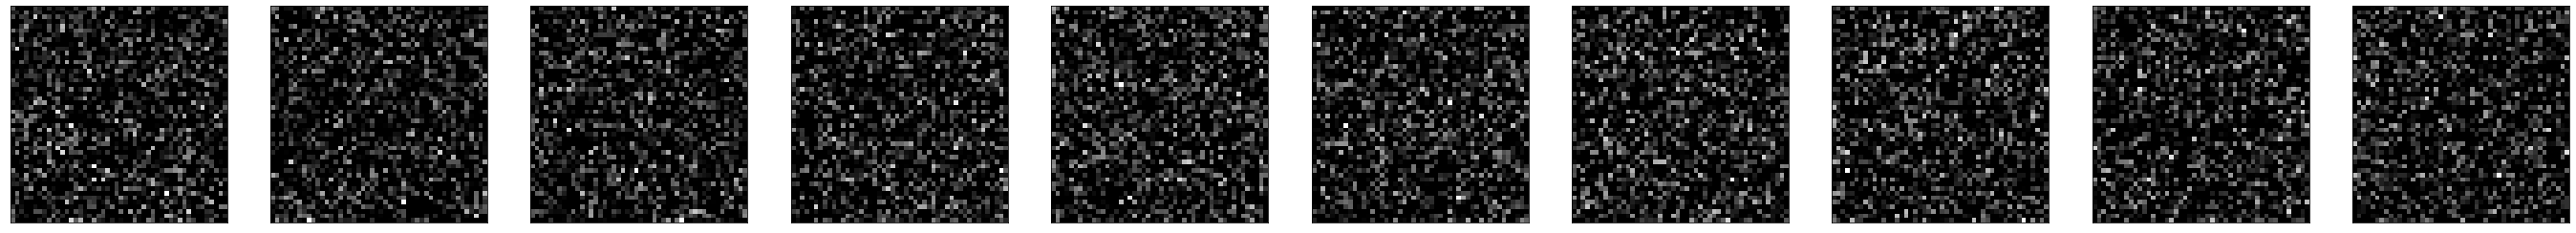

In [28]:
plt.figure(figsize=(48, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

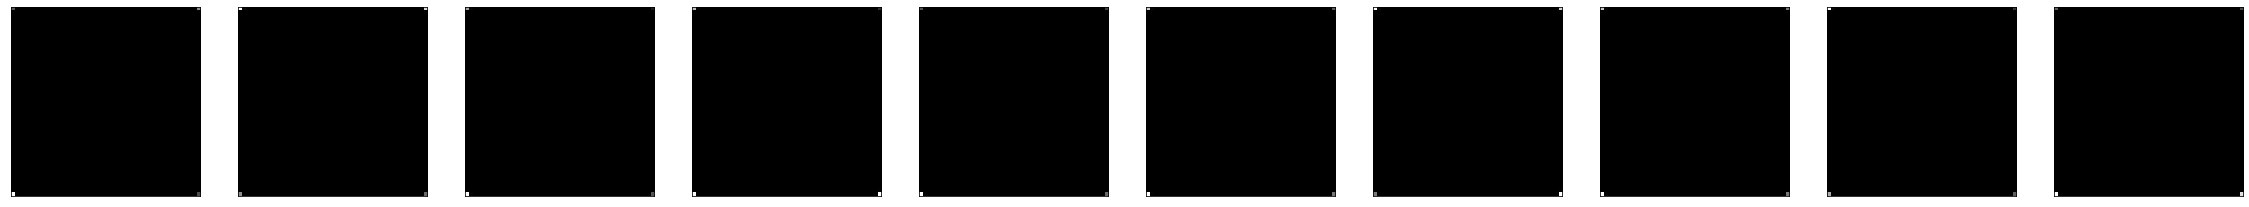

In [29]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()